# 3 layer Conv Encoder, LSTM Decoder. 120 day input, 3 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.layers import Input
from keras.models import Sequential, load_model, Model
from sklearn.metrics import mean_squared_error, accuracy_score
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm11'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [3]:
num_input = 120
num_out = 3
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)

train_X shape (568, 120, 25)
train_y shape (568, 3, 1)
dev_X shape (71, 120, 25)
dev_y shape (71, 3, 1)
test_X shape (72, 120, 25)
test_y shape (72, 3, 1)
train_y_acc shape (568, 3, 1)
dev_y_acc shape (71, 3, 1)
test_y_acc shape (72, 3, 1)


In [5]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.4
epochs = 500
batch_size = 32

Input_X = Input(shape=input_shape)
X = Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005))(Input_X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = Conv1D(filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = MaxPooling1D(pool_size=2)(X)

X = Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = CuDNNLSTM(200, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01))(X)
X = RepeatVector(num_out)(X)

X = CuDNNLSTM(200, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(X)

X_mse = TimeDistributed(Dense(100, activation='relu'))(X)
out_mse = TimeDistributed(Dense(1, name='mse'))(X_mse)

X_binary = TimeDistributed(Dense(100, activation='relu'))(X)
out_binary = TimeDistributed(Dense(1, activation='sigmoid', name='binary'))(X_binary)

model = Model(inputs=[Input_X], outputs=[out_mse, out_binary])

opt = Adam(lr=lr, decay=decay)
model.compile(loss=["mse", "binary_crossentropy"], optimizer=opt)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 120, 25)      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 118, 64)      4864        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 118, 64)      256         conv1d_4[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 118, 64)      0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
dropout_4 

In [6]:
history = model_funcs.train(
    model,
    train_X,
    [train_y, train_y_acc],
    (dev_X, [dev_y, dev_y_acc]),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 500 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 568 samples, validate on 71 samples
Epoch 1/500
568/568 [==============================] - 3s 5ms/step - loss: 6.4557 - time_distributed_6_loss: 0.0291 - time_distributed_8_loss: 0.6922 - val_loss: 4.7008 - val_time_distributed_6_loss: 0.0126 - val_time_distributed_8_loss: 0.6995
Epoch 2/500
568/568 [==============================] - 1s 945us/step - loss: 3.6175 - time_distributed_6_loss: 0.0072 - time_distributed_8_loss: 0.6894 - val_loss: 2.6328 - val_time_distributed_6_loss: 0.0110 - val_time_distributed_8_loss: 0.6942
Epoch 3/500
568/568 [==============================] - 1s 918us/step - loss: 2.0724 - time_distributed_6_loss: 0.0065 - time_distributed_8_loss: 0.6864 - val_loss: 1.5896 - val_time_distributed_6_loss: 0.0059 - val_time_distributed_8_loss: 0.6961
Epoch 4/500
568/568 [==============================] - 1s 896us/step - loss: 1.3212 - time_distributed_6_loss

568/568 [==============================] - 0s 878us/step - loss: 0.6869 - time_distributed_6_loss: 0.0041 - time_distributed_8_loss: 0.6442 - val_loss: 0.7445 - val_time_distributed_6_loss: 0.0012 - val_time_distributed_8_loss: 0.7056
Epoch 33/500
568/568 [==============================] - 1s 886us/step - loss: 0.7026 - time_distributed_6_loss: 0.0069 - time_distributed_8_loss: 0.6574 - val_loss: 0.7490 - val_time_distributed_6_loss: 0.0018 - val_time_distributed_8_loss: 0.7084
Epoch 34/500
568/568 [==============================] - 1s 883us/step - loss: 0.6905 - time_distributed_6_loss: 0.0036 - time_distributed_8_loss: 0.6482 - val_loss: 0.7484 - val_time_distributed_6_loss: 0.0078 - val_time_distributed_8_loss: 0.7025
Epoch 35/500
568/568 [==============================] - 0s 875us/step - loss: 0.6881 - time_distributed_6_loss: 0.0039 - time_distributed_8_loss: 0.6458 - val_loss: 0.7487 - val_time_distributed_6_loss: 0.0115 - val_time_distributed_8_loss: 0.6973
Epoch 36/500
568/568 

568/568 [==============================] - 1s 896us/step - loss: 0.6941 - time_distributed_6_loss: 0.0033 - time_distributed_8_loss: 0.6279 - val_loss: 0.8261 - val_time_distributed_6_loss: 0.0266 - val_time_distributed_8_loss: 0.7346
Epoch 66/500
568/568 [==============================] - 0s 875us/step - loss: 0.6927 - time_distributed_6_loss: 0.0043 - time_distributed_8_loss: 0.6242 - val_loss: 0.7887 - val_time_distributed_6_loss: 0.0017 - val_time_distributed_8_loss: 0.7240
Epoch 67/500
568/568 [==============================] - 0s 875us/step - loss: 0.6939 - time_distributed_6_loss: 0.0055 - time_distributed_8_loss: 0.6242 - val_loss: 0.8043 - val_time_distributed_6_loss: 0.0106 - val_time_distributed_8_loss: 0.7287
Epoch 68/500
568/568 [==============================] - 0s 880us/step - loss: 0.6823 - time_distributed_6_loss: 0.0059 - time_distributed_8_loss: 0.6124 - val_loss: 0.8912 - val_time_distributed_6_loss: 0.0457 - val_time_distributed_8_loss: 0.7829
Epoch 69/500
568/568 

568/568 [==============================] - 0s 877us/step - loss: 0.6985 - time_distributed_6_loss: 0.0069 - time_distributed_8_loss: 0.5827 - val_loss: 0.9586 - val_time_distributed_6_loss: 0.0076 - val_time_distributed_8_loss: 0.8476
Epoch 99/500
568/568 [==============================] - 1s 887us/step - loss: 0.6822 - time_distributed_6_loss: 0.0036 - time_distributed_8_loss: 0.5792 - val_loss: 1.0525 - val_time_distributed_6_loss: 0.0188 - val_time_distributed_8_loss: 0.9380
Epoch 100/500
568/568 [==============================] - 0s 875us/step - loss: 0.6628 - time_distributed_6_loss: 0.0045 - time_distributed_8_loss: 0.5644 - val_loss: 0.9790 - val_time_distributed_6_loss: 0.0150 - val_time_distributed_8_loss: 0.8729
Epoch 101/500
568/568 [==============================] - 0s 874us/step - loss: 0.6624 - time_distributed_6_loss: 0.0033 - time_distributed_8_loss: 0.5668 - val_loss: 0.9429 - val_time_distributed_6_loss: 0.0079 - val_time_distributed_8_loss: 0.8451
Epoch 102/500
568/5

Epoch 131/500
568/568 [==============================] - 1s 882us/step - loss: 0.6394 - time_distributed_6_loss: 0.0024 - time_distributed_8_loss: 0.5019 - val_loss: 1.0028 - val_time_distributed_6_loss: 0.0071 - val_time_distributed_8_loss: 0.8642
Epoch 132/500
568/568 [==============================] - 1s 884us/step - loss: 0.6083 - time_distributed_6_loss: 0.0022 - time_distributed_8_loss: 0.4776 - val_loss: 1.0500 - val_time_distributed_6_loss: 0.0204 - val_time_distributed_8_loss: 0.9065
Epoch 133/500
568/568 [==============================] - 1s 882us/step - loss: 0.6422 - time_distributed_6_loss: 0.0030 - time_distributed_8_loss: 0.5154 - val_loss: 1.0052 - val_time_distributed_6_loss: 0.0173 - val_time_distributed_8_loss: 0.8592
Epoch 134/500
568/568 [==============================] - 1s 887us/step - loss: 0.6794 - time_distributed_6_loss: 0.0039 - time_distributed_8_loss: 0.5404 - val_loss: 0.9662 - val_time_distributed_6_loss: 0.0135 - val_time_distributed_8_loss: 0.8149
Epoc

Epoch 164/500
568/568 [==============================] - 0s 877us/step - loss: 0.5466 - time_distributed_6_loss: 0.0017 - time_distributed_8_loss: 0.3841 - val_loss: 1.3956 - val_time_distributed_6_loss: 0.0039 - val_time_distributed_8_loss: 1.2316
Epoch 165/500
568/568 [==============================] - 1s 883us/step - loss: 0.6087 - time_distributed_6_loss: 0.0018 - time_distributed_8_loss: 0.4479 - val_loss: 1.0905 - val_time_distributed_6_loss: 0.0017 - val_time_distributed_8_loss: 0.9300
Epoch 166/500
568/568 [==============================] - 0s 873us/step - loss: 0.5965 - time_distributed_6_loss: 0.0021 - time_distributed_8_loss: 0.4366 - val_loss: 1.1635 - val_time_distributed_6_loss: 8.8726e-04 - val_time_distributed_8_loss: 1.0048
Epoch 167/500
568/568 [==============================] - 0s 873us/step - loss: 0.5980 - time_distributed_6_loss: 0.0024 - time_distributed_8_loss: 0.4278 - val_loss: 1.2332 - val_time_distributed_6_loss: 0.0462 - val_time_distributed_8_loss: 1.0073


Epoch 197/500
568/568 [==============================] - 0s 872us/step - loss: 0.4991 - time_distributed_6_loss: 0.0017 - time_distributed_8_loss: 0.3154 - val_loss: 1.2008 - val_time_distributed_6_loss: 0.0012 - val_time_distributed_8_loss: 1.0072
Epoch 198/500
568/568 [==============================] - 1s 882us/step - loss: 0.5696 - time_distributed_6_loss: 0.0029 - time_distributed_8_loss: 0.3650 - val_loss: 1.3823 - val_time_distributed_6_loss: 0.0081 - val_time_distributed_8_loss: 1.1580
Epoch 199/500
568/568 [==============================] - 1s 882us/step - loss: 0.5719 - time_distributed_6_loss: 0.0020 - time_distributed_8_loss: 0.3478 - val_loss: 1.4594 - val_time_distributed_6_loss: 0.0129 - val_time_distributed_8_loss: 1.2171
Epoch 200/500
568/568 [==============================] - 1s 891us/step - loss: 0.6250 - time_distributed_6_loss: 0.0022 - time_distributed_8_loss: 0.3742 - val_loss: 1.3074 - val_time_distributed_6_loss: 0.0174 - val_time_distributed_8_loss: 1.0302
Epoc

Epoch 230/500
568/568 [==============================] - 1s 881us/step - loss: 0.7609 - time_distributed_6_loss: 0.0060 - time_distributed_8_loss: 0.6195 - val_loss: 0.9270 - val_time_distributed_6_loss: 0.0115 - val_time_distributed_8_loss: 0.7819
Epoch 231/500
568/568 [==============================] - 1s 889us/step - loss: 0.7457 - time_distributed_6_loss: 0.0061 - time_distributed_8_loss: 0.6074 - val_loss: 0.8807 - val_time_distributed_6_loss: 0.0110 - val_time_distributed_8_loss: 0.7394
Epoch 232/500
568/568 [==============================] - 1s 885us/step - loss: 0.7364 - time_distributed_6_loss: 0.0064 - time_distributed_8_loss: 0.6016 - val_loss: 0.8780 - val_time_distributed_6_loss: 0.0083 - val_time_distributed_8_loss: 0.7433
Epoch 233/500
568/568 [==============================] - 1s 886us/step - loss: 0.7242 - time_distributed_6_loss: 0.0054 - time_distributed_8_loss: 0.5936 - val_loss: 0.8809 - val_time_distributed_6_loss: 0.0110 - val_time_distributed_8_loss: 0.7469
Epoc

Epoch 263/500
568/568 [==============================] - 1s 888us/step - loss: 0.5664 - time_distributed_6_loss: 0.0030 - time_distributed_8_loss: 0.4313 - val_loss: 1.1021 - val_time_distributed_6_loss: 0.0233 - val_time_distributed_8_loss: 0.9465
Epoch 264/500
568/568 [==============================] - 1s 884us/step - loss: 0.5725 - time_distributed_6_loss: 0.0032 - time_distributed_8_loss: 0.4357 - val_loss: 1.1827 - val_time_distributed_6_loss: 0.0138 - val_time_distributed_8_loss: 1.0327
Epoch 265/500
568/568 [==============================] - 0s 876us/step - loss: 0.6082 - time_distributed_6_loss: 0.0033 - time_distributed_8_loss: 0.4670 - val_loss: 1.0071 - val_time_distributed_6_loss: 0.0273 - val_time_distributed_8_loss: 0.8409
Epoch 266/500
568/568 [==============================] - 1s 887us/step - loss: 0.5869 - time_distributed_6_loss: 0.0037 - time_distributed_8_loss: 0.4441 - val_loss: 1.1173 - val_time_distributed_6_loss: 0.0323 - val_time_distributed_8_loss: 0.9475
Epoc

Epoch 296/500
568/568 [==============================] - 1s 886us/step - loss: 0.4384 - time_distributed_6_loss: 0.0016 - time_distributed_8_loss: 0.2666 - val_loss: 2.0866 - val_time_distributed_6_loss: 0.0155 - val_time_distributed_8_loss: 1.9038
Epoch 297/500
568/568 [==============================] - 1s 889us/step - loss: 0.4569 - time_distributed_6_loss: 0.0021 - time_distributed_8_loss: 0.2848 - val_loss: 1.8208 - val_time_distributed_6_loss: 0.0212 - val_time_distributed_8_loss: 1.6269
Epoch 298/500
568/568 [==============================] - 1s 892us/step - loss: 0.4602 - time_distributed_6_loss: 0.0022 - time_distributed_8_loss: 0.2844 - val_loss: 1.6766 - val_time_distributed_6_loss: 0.0144 - val_time_distributed_8_loss: 1.4903
Epoch 299/500
568/568 [==============================] - 0s 876us/step - loss: 0.4239 - time_distributed_6_loss: 0.0019 - time_distributed_8_loss: 0.2528 - val_loss: 1.7547 - val_time_distributed_6_loss: 0.0152 - val_time_distributed_8_loss: 1.5745
Epoc

Epoch 329/500
568/568 [==============================] - 1s 892us/step - loss: 0.8223 - time_distributed_6_loss: 0.0067 - time_distributed_8_loss: 0.5933 - val_loss: 1.0074 - val_time_distributed_6_loss: 0.0259 - val_time_distributed_8_loss: 0.7695
Epoch 330/500
568/568 [==============================] - 1s 889us/step - loss: 0.7641 - time_distributed_6_loss: 0.0053 - time_distributed_8_loss: 0.5539 - val_loss: 0.9919 - val_time_distributed_6_loss: 0.0242 - val_time_distributed_8_loss: 0.7708
Epoch 331/500
568/568 [==============================] - 1s 881us/step - loss: 0.7288 - time_distributed_6_loss: 0.0064 - time_distributed_8_loss: 0.5300 - val_loss: 1.1084 - val_time_distributed_6_loss: 0.0270 - val_time_distributed_8_loss: 0.8931
Epoch 332/500
568/568 [==============================] - 0s 878us/step - loss: 0.6886 - time_distributed_6_loss: 0.0053 - time_distributed_8_loss: 0.4974 - val_loss: 1.2509 - val_time_distributed_6_loss: 0.0160 - val_time_distributed_8_loss: 1.0501
Epoc

Epoch 362/500
568/568 [==============================] - 1s 890us/step - loss: 1.0072 - time_distributed_6_loss: 0.0138 - time_distributed_8_loss: 0.5620 - val_loss: 1.2779 - val_time_distributed_6_loss: 0.0235 - val_time_distributed_8_loss: 0.8032
Epoch 363/500
568/568 [==============================] - 1s 881us/step - loss: 0.9356 - time_distributed_6_loss: 0.0096 - time_distributed_8_loss: 0.4887 - val_loss: 1.2239 - val_time_distributed_6_loss: 0.0138 - val_time_distributed_8_loss: 0.7946
Epoch 364/500
568/568 [==============================] - 1s 889us/step - loss: 0.8180 - time_distributed_6_loss: 0.0067 - time_distributed_8_loss: 0.4157 - val_loss: 1.3084 - val_time_distributed_6_loss: 0.0054 - val_time_distributed_8_loss: 0.9281
Epoch 365/500
568/568 [==============================] - 1s 891us/step - loss: 0.7074 - time_distributed_6_loss: 0.0056 - time_distributed_8_loss: 0.3421 - val_loss: 1.3722 - val_time_distributed_6_loss: 0.0130 - val_time_distributed_8_loss: 1.0163
Epoc

Epoch 395/500
568/568 [==============================] - 1s 892us/step - loss: 1.0281 - time_distributed_6_loss: 0.0173 - time_distributed_8_loss: 0.6318 - val_loss: 1.1497 - val_time_distributed_6_loss: 0.0251 - val_time_distributed_8_loss: 0.7333
Epoch 396/500
568/568 [==============================] - 1s 892us/step - loss: 0.9392 - time_distributed_6_loss: 0.0079 - time_distributed_8_loss: 0.5588 - val_loss: 1.1004 - val_time_distributed_6_loss: 0.0095 - val_time_distributed_8_loss: 0.7421
Epoch 397/500
568/568 [==============================] - 1s 887us/step - loss: 0.8263 - time_distributed_6_loss: 0.0052 - time_distributed_8_loss: 0.4880 - val_loss: 1.1229 - val_time_distributed_6_loss: 0.0076 - val_time_distributed_8_loss: 0.7971
Epoch 398/500
568/568 [==============================] - 1s 888us/step - loss: 0.7342 - time_distributed_6_loss: 0.0043 - time_distributed_8_loss: 0.4217 - val_loss: 1.2328 - val_time_distributed_6_loss: 0.0205 - val_time_distributed_8_loss: 0.9147
Epoc

Epoch 428/500
568/568 [==============================] - 1s 888us/step - loss: 0.3025 - time_distributed_6_loss: 0.0014 - time_distributed_8_loss: 0.0912 - val_loss: 1.9567 - val_time_distributed_6_loss: 0.0168 - val_time_distributed_8_loss: 1.7333
Epoch 429/500
568/568 [==============================] - 1s 880us/step - loss: 0.3436 - time_distributed_6_loss: 0.0016 - time_distributed_8_loss: 0.1371 - val_loss: 1.9097 - val_time_distributed_6_loss: 0.0224 - val_time_distributed_8_loss: 1.6820
Epoch 430/500
568/568 [==============================] - 1s 888us/step - loss: 0.4857 - time_distributed_6_loss: 0.0015 - time_distributed_8_loss: 0.2756 - val_loss: 2.0634 - val_time_distributed_6_loss: 0.0082 - val_time_distributed_8_loss: 1.8186
Epoch 431/500
568/568 [==============================] - 1s 892us/step - loss: 0.9323 - time_distributed_6_loss: 0.0084 - time_distributed_8_loss: 0.6253 - val_loss: 1.1272 - val_time_distributed_6_loss: 0.0101 - val_time_distributed_8_loss: 0.7497
Epoc

Epoch 461/500
568/568 [==============================] - 1s 889us/step - loss: 0.7131 - time_distributed_6_loss: 0.0026 - time_distributed_8_loss: 0.3745 - val_loss: 1.1706 - val_time_distributed_6_loss: 0.0185 - val_time_distributed_8_loss: 0.8245
Epoch 462/500
568/568 [==============================] - 1s 897us/step - loss: 0.6709 - time_distributed_6_loss: 0.0025 - time_distributed_8_loss: 0.3472 - val_loss: 1.1626 - val_time_distributed_6_loss: 0.0204 - val_time_distributed_8_loss: 0.8287
Epoch 463/500
568/568 [==============================] - 1s 887us/step - loss: 0.6986 - time_distributed_6_loss: 0.0046 - time_distributed_8_loss: 0.3821 - val_loss: 1.2991 - val_time_distributed_6_loss: 0.0171 - val_time_distributed_8_loss: 0.9730
Epoch 464/500
568/568 [==============================] - 1s 889us/step - loss: 0.6726 - time_distributed_6_loss: 0.0028 - time_distributed_8_loss: 0.3606 - val_loss: 1.3505 - val_time_distributed_6_loss: 0.0187 - val_time_distributed_8_loss: 1.0222
Epoc

Epoch 494/500
568/568 [==============================] - 1s 888us/step - loss: 0.9898 - time_distributed_6_loss: 0.0069 - time_distributed_8_loss: 0.6457 - val_loss: 1.0726 - val_time_distributed_6_loss: 0.0044 - val_time_distributed_8_loss: 0.7375
Epoch 495/500
568/568 [==============================] - 1s 883us/step - loss: 0.9777 - time_distributed_6_loss: 0.0048 - time_distributed_8_loss: 0.6480 - val_loss: 1.0801 - val_time_distributed_6_loss: 0.0069 - val_time_distributed_8_loss: 0.7546
Epoch 496/500
568/568 [==============================] - 1s 888us/step - loss: 0.9576 - time_distributed_6_loss: 0.0052 - time_distributed_8_loss: 0.6391 - val_loss: 1.0708 - val_time_distributed_6_loss: 0.0114 - val_time_distributed_8_loss: 0.7525
Epoch 497/500
568/568 [==============================] - 0s 879us/step - loss: 0.9277 - time_distributed_6_loss: 0.0046 - time_distributed_8_loss: 0.6214 - val_loss: 1.0932 - val_time_distributed_6_loss: 0.0087 - val_time_distributed_8_loss: 0.7884
Epoc

In [67]:
predicted_train = model.predict(train_X)
predicted_train_mse = predicted_train[0].squeeze()
predicted_train_sigmoid = predicted_train[1].squeeze()
print(predicted_train_mse.shape, predicted_train_binary.shape)

predicted_dev = model.predict(dev_X)
predicted_dev_mse = predicted_dev[0].squeeze()
predicted_dev_sigmoid = predicted_dev[1].squeeze()

predicted_test = model.predict(test_X)
predicted_test_mse = predicted_test[0].squeeze()
predicted_test_sigmoid = predicted_test[1].squeeze()

(568, 3) (568, 1)


In [30]:
true_train = train_y_acc[:, 0].reshape(-1,1)
predicted_train_binary = predicted_train_sigmoid[::num_out].reshape(-1,1)[:true_train.shape[0]]
predicted_train_binary = np.array(predicted_train_binary > 0.5, dtype=np.int32)
print('Train Acc:', accuracy_score(prepredicted_train_binary, true_train))

true_dev = dev_y_acc[:, 0].reshape(-1,1)
predicted_dev = predicted_dev_sigmoid[::num_out].reshape(-1,1)[:true_dev.shape[0]]
prepredicted_dev_binary = np.array(predicted_dev > 0.5, dtype=np.int32)
print('Dev Acc:', accuracy_score(prepredicted_dev_binary, true_dev))

true_test = test_y_acc[:, 0].reshape(-1,1)
predicted_test = predicted_test_sigmoid[::num_out].reshape(-1,1)[:true_test.shape[0]]
prepredicted_test_binary = np.array(predicted_test > 0.5, dtype=np.int32)
print('Test Acc:', accuracy_score(prepredicted_test_binary, true_test))

Train Acc: 0.6161971830985915
Dev Acc: 0.4788732394366197
Test Acc: 0.6388888888888888


In [19]:
true_train = train_y_acc.reshape(-1,1)
predicted_train_mse, predicted_train = model.predict(train_X)
predicted_train = predicted_train.reshape(-1,1)
prepredicted_train_binary = np.array(predicted_train > 0.5, dtype=np.int32)
print('Train Acc:', accuracy_score(prepredicted_train_binary, true_train))

Train Acc: 0.6126760563380281


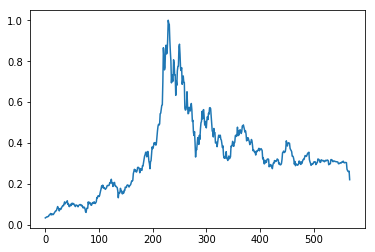

In [60]:
true_train_mse = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train_mse[::num_out].tolist(), true_train_mse, num_out)

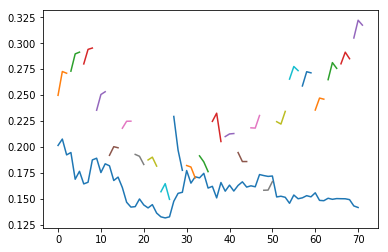

In [32]:
true_dev_mse = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev_mse[::num_out].tolist(), true_dev_mse, num_out)

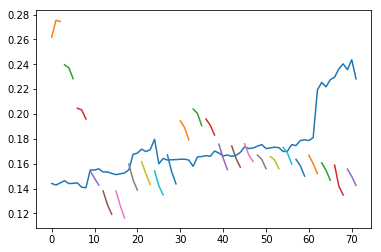

In [35]:
true_test_mse = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test_mse[::num_out].tolist(), true_test_mse, num_out)

In [68]:
print("MSE Train:", mean_squared_error(predicted_train_mse.flatten(), train_y.flatten()))
print("MSE Dev:", mean_squared_error(predicted_dev_mse.flatten(), dev_y.flatten()))
print("MSE Test:", mean_squared_error(predicted_test_mse.flatten(), test_y.flatten()))

MSE Train: 0.013815110732493655
MSE Dev: 0.007090521327570259
MSE Test: 0.002300262602886424


In [59]:
true_train_acc = train_y_acc.reshape(-1,1)
true_dev_acc = dev_y_acc.reshape(-1,1)
true_test_acc = test_y_acc.reshape(-1,1)

print("Acc Train:", accuracy_score(np.array(predicted_train_mse > 0.5,dtype=np.int32), np.array(true_train_acc,dtype=np.int32)))
print("Acc Dev:", accuracy_score(np.array(predicted_dev_mse > 0.5,dtype=np.int32), np.array(true_dev_acc,dtype=np.int32)))
print("Acc Test:", accuracy_score(np.array(predicted_test_mse > 0.5,dtype=np.int32), np.array(true_test_acc,dtype=np.int32)))

print("Acc Train:", accuracy_score(np.array(predicted_train_binary > 0.5,dtype=np.int32), np.array(true_train_acc,dtype=np.int32)))
print("Acc Dev:", accuracy_score(np.array(predicted_dev_binary > 0.5,dtype=np.int32), np.array(true_dev_acc,dtype=np.int32)))
print("Acc Test:", accuracy_score(np.array(predicted_test_binary > 0.5,dtype=np.int32), np.array(true_test_acc,dtype=np.int32)))


Acc Train: 0.5469255663430421
Acc Dev: 0.45454545454545453
Acc Test: 0.6153846153846154
Acc Train: 0.5760517799352751
Acc Dev: 0.45454545454545453
Acc Test: 0.6153846153846154


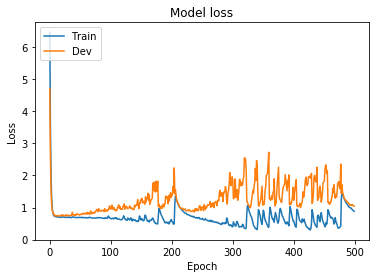

In [37]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

(618, 1)
0.37891430449796265


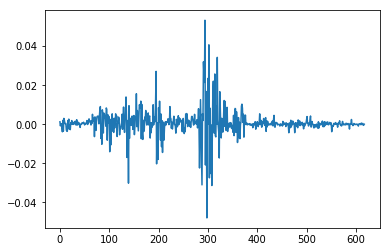

In [48]:
print(true_train.shape)
scores, scores_normalized = utils.get_scores(true_train, predicted_train_binary.reshape(-1,1)[:true_train.shape[0]], num_out)
print(np.sum(scores))
plt.plot(scores)

0.12709474614724767


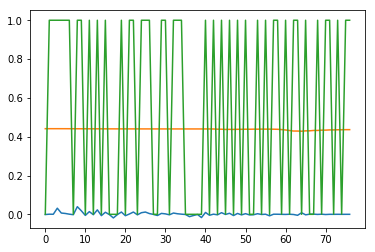

In [56]:
scores, scores_normalized = utils.get_scores(true_dev, predicted_dev_binary.reshape(-1,1), num_out)
print(np.sum(scores))
plt.plot(scores)
plt.plot(predicted_dev_binary.reshape(-1,1))
plt.plot(true_dev_acc)

0.0297960213243301


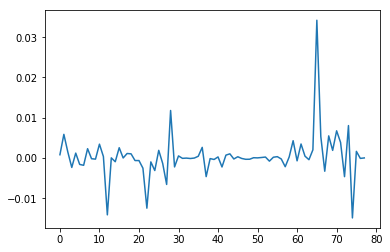

In [50]:
scores, scores_normalized = utils.get_scores(true_test, predicted_test_binary.reshape(-1,1), num_out)
print(np.sum(scores))
plt.plot(scores)

In [60]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0001
decay = 1e-6
dropout_rate = 0.5
epochs = 500
batch_size = 32

Input_X = Input(shape=input_shape)
X = Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.005))(Input_X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = Conv1D(filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = MaxPooling1D(pool_size=2)(X)

X = Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.01))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = LSTM(200, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01))(X)
X = RepeatVector(num_out)(X)

X = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(X)

X_mse = TimeDistributed(Dense(100, activation='relu'))(X)
out_mse = TimeDistributed(Dense(1))(X_mse)

X_binary = TimeDistributed(Dense(100, activation='relu'))(X)
out_binary = TimeDistributed(Dense(1, activation='sigmoid'))(X_binary)

model = Model(inputs=[Input_X], outputs=[out_mse, out_binary])

opt = Adam(lr=lr, decay=decay)
model.compile(loss=["mse", "binary_crossentropy"], optimizer=opt)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 25)       0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 58, 64)       4864        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 58, 64)       256         conv1d_10[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 58, 64)       0           batch_normalization_10[0][0]     
__________________________________________________________________________________________________
dropout_10

In [61]:
history = model_funcs.train(
    model,
    train_X,
    [train_y, train_y_acc],
    (dev_X, [dev_y, dev_y_acc]),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 500 epochs, 32 batch size
Train on 618 samples, validate on 77 samples
Epoch 1/500
618/618 [==============================] - 4s 7ms/step - loss: 7.9872 - time_distributed_14_loss: 0.0709 - time_distributed_16_loss: 0.6930 - val_loss: 7.6669 - val_time_distributed_14_loss: 0.0093 - val_time_distributed_16_loss: 0.6940
Epoch 2/500
618/618 [==============================] - 1s 2ms/step - loss: 7.4695 - time_distributed_14_loss: 0.0274 - time_distributed_16_loss: 0.6920 - val_loss: 7.2025 - val_time_distributed_14_loss: 0.0062 - val_time_distributed_16_loss: 0.6942
Epoch 3/500
618/618 [==============================] - 1s 2ms/step - loss: 7.0143 - time_distributed_14_loss: 0.0219 - time_distributed_16_loss: 0.6913 - val_loss: 6.7679 - val_time_distributed_14_loss: 0.0043 - val_time_distributed_16_loss: 0.6950
Epoch 4/500
618/618 [==============================] - 1s 2ms/step - loss: 6.5890 - time_distributed_14_loss: 0.0178 - time_distributed_16_loss: 0.69

Epoch 66/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7850 - time_distributed_14_loss: 0.0046 - time_distributed_16_loss: 0.6692 - val_loss: 0.8054 - val_time_distributed_14_loss: 0.0016 - val_time_distributed_16_loss: 0.6945
Epoch 67/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7832 - time_distributed_14_loss: 0.0043 - time_distributed_16_loss: 0.6713 - val_loss: 0.7993 - val_time_distributed_14_loss: 0.0014 - val_time_distributed_16_loss: 0.6923
Epoch 68/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7781 - time_distributed_14_loss: 0.0057 - time_distributed_16_loss: 0.6682 - val_loss: 0.7986 - val_time_distributed_14_loss: 0.0019 - val_time_distributed_16_loss: 0.6942
Epoch 69/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7696 - time_distributed_14_loss: 0.0038 - time_distributed_16_loss: 0.6647 - val_loss: 0.7934 - val_time_distributed_14_loss: 0.0025 - val_time_distributed_16_loss: 0.6913


Epoch 99/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7135 - time_distributed_14_loss: 0.0032 - time_distributed_16_loss: 0.6511 - val_loss: 0.7503 - val_time_distributed_14_loss: 0.0030 - val_time_distributed_16_loss: 0.6885
Epoch 100/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7115 - time_distributed_14_loss: 0.0030 - time_distributed_16_loss: 0.6499 - val_loss: 0.7569 - val_time_distributed_14_loss: 0.0056 - val_time_distributed_16_loss: 0.6930
Epoch 101/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7077 - time_distributed_14_loss: 0.0033 - time_distributed_16_loss: 0.6461 - val_loss: 0.7540 - val_time_distributed_14_loss: 0.0052 - val_time_distributed_16_loss: 0.6907
Epoch 102/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7172 - time_distributed_14_loss: 0.0030 - time_distributed_16_loss: 0.6565 - val_loss: 0.7612 - val_time_distributed_14_loss: 0.0084 - val_time_distributed_16_loss: 0.69

Epoch 132/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6950 - time_distributed_14_loss: 0.0042 - time_distributed_16_loss: 0.6409 - val_loss: 0.7651 - val_time_distributed_14_loss: 0.0156 - val_time_distributed_16_loss: 0.6998
Epoch 133/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6846 - time_distributed_14_loss: 0.0037 - time_distributed_16_loss: 0.6312 - val_loss: 0.8012 - val_time_distributed_14_loss: 0.0222 - val_time_distributed_16_loss: 0.7294
Epoch 134/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6900 - time_distributed_14_loss: 0.0029 - time_distributed_16_loss: 0.6375 - val_loss: 0.7689 - val_time_distributed_14_loss: 0.0138 - val_time_distributed_16_loss: 0.7057
Epoch 135/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6794 - time_distributed_14_loss: 0.0025 - time_distributed_16_loss: 0.6275 - val_loss: 0.7639 - val_time_distributed_14_loss: 0.0136 - val_time_distributed_16_loss: 0.7

Epoch 165/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6680 - time_distributed_14_loss: 0.0043 - time_distributed_16_loss: 0.6144 - val_loss: 0.8156 - val_time_distributed_14_loss: 0.0121 - val_time_distributed_16_loss: 0.7541
Epoch 166/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6587 - time_distributed_14_loss: 0.0041 - time_distributed_16_loss: 0.6051 - val_loss: 0.8626 - val_time_distributed_14_loss: 0.0179 - val_time_distributed_16_loss: 0.7952
Epoch 167/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6684 - time_distributed_14_loss: 0.0044 - time_distributed_16_loss: 0.6145 - val_loss: 0.8177 - val_time_distributed_14_loss: 0.0157 - val_time_distributed_16_loss: 0.7524
Epoch 168/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6629 - time_distributed_14_loss: 0.0037 - time_distributed_16_loss: 0.6095 - val_loss: 0.7929 - val_time_distributed_14_loss: 0.0131 - val_time_distributed_16_loss: 0.7

Epoch 198/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6181 - time_distributed_14_loss: 0.0044 - time_distributed_16_loss: 0.5606 - val_loss: 0.8457 - val_time_distributed_14_loss: 0.0177 - val_time_distributed_16_loss: 0.7749
Epoch 199/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6169 - time_distributed_14_loss: 0.0028 - time_distributed_16_loss: 0.5608 - val_loss: 0.8500 - val_time_distributed_14_loss: 0.0113 - val_time_distributed_16_loss: 0.7853
Epoch 200/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6281 - time_distributed_14_loss: 0.0035 - time_distributed_16_loss: 0.5712 - val_loss: 0.8335 - val_time_distributed_14_loss: 0.0132 - val_time_distributed_16_loss: 0.7666
Epoch 201/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6081 - time_distributed_14_loss: 0.0073 - time_distributed_16_loss: 0.5471 - val_loss: 0.8117 - val_time_distributed_14_loss: 0.0069 - val_time_distributed_16_loss: 0.7

Epoch 231/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5976 - time_distributed_14_loss: 0.0042 - time_distributed_16_loss: 0.5369 - val_loss: 0.8334 - val_time_distributed_14_loss: 0.0105 - val_time_distributed_16_loss: 0.7662
Epoch 232/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5859 - time_distributed_14_loss: 0.0048 - time_distributed_16_loss: 0.5243 - val_loss: 0.8624 - val_time_distributed_14_loss: 0.0067 - val_time_distributed_16_loss: 0.7989
Epoch 233/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5603 - time_distributed_14_loss: 0.0047 - time_distributed_16_loss: 0.4986 - val_loss: 0.8768 - val_time_distributed_14_loss: 0.0085 - val_time_distributed_16_loss: 0.8112
Epoch 234/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6256 - time_distributed_14_loss: 0.0054 - time_distributed_16_loss: 0.5630 - val_loss: 0.8674 - val_time_distributed_14_loss: 0.0022 - val_time_distributed_16_loss: 0.8

Epoch 264/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5442 - time_distributed_14_loss: 0.0045 - time_distributed_16_loss: 0.4788 - val_loss: 0.8998 - val_time_distributed_14_loss: 0.0134 - val_time_distributed_16_loss: 0.8255
Epoch 265/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5219 - time_distributed_14_loss: 0.0045 - time_distributed_16_loss: 0.4564 - val_loss: 0.9305 - val_time_distributed_14_loss: 0.0073 - val_time_distributed_16_loss: 0.8622
Epoch 266/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5603 - time_distributed_14_loss: 0.0059 - time_distributed_16_loss: 0.4933 - val_loss: 0.9234 - val_time_distributed_14_loss: 0.0116 - val_time_distributed_16_loss: 0.8505
Epoch 267/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5542 - time_distributed_14_loss: 0.0042 - time_distributed_16_loss: 0.4887 - val_loss: 0.8981 - val_time_distributed_14_loss: 0.0077 - val_time_distributed_16_loss: 0.8

Epoch 297/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5324 - time_distributed_14_loss: 0.0045 - time_distributed_16_loss: 0.4631 - val_loss: 0.9058 - val_time_distributed_14_loss: 0.0062 - val_time_distributed_16_loss: 0.8347
Epoch 298/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6160 - time_distributed_14_loss: 0.0049 - time_distributed_16_loss: 0.5456 - val_loss: 0.8817 - val_time_distributed_14_loss: 0.0104 - val_time_distributed_16_loss: 0.8049
Epoch 299/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5477 - time_distributed_14_loss: 0.0042 - time_distributed_16_loss: 0.4765 - val_loss: 0.8700 - val_time_distributed_14_loss: 0.0081 - val_time_distributed_16_loss: 0.7946
Epoch 300/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5397 - time_distributed_14_loss: 0.0038 - time_distributed_16_loss: 0.4685 - val_loss: 0.9644 - val_time_distributed_14_loss: 0.0149 - val_time_distributed_16_loss: 0.8

Epoch 330/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4893 - time_distributed_14_loss: 0.0027 - time_distributed_16_loss: 0.4178 - val_loss: 0.9028 - val_time_distributed_14_loss: 0.0055 - val_time_distributed_16_loss: 0.8285
Epoch 331/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4618 - time_distributed_14_loss: 0.0031 - time_distributed_16_loss: 0.3898 - val_loss: 0.9565 - val_time_distributed_14_loss: 0.0049 - val_time_distributed_16_loss: 0.8825
Epoch 332/500
618/618 [==============================] - 1s 2ms/step - loss: 0.5103 - time_distributed_14_loss: 0.0040 - time_distributed_16_loss: 0.4372 - val_loss: 0.9312 - val_time_distributed_14_loss: 0.0046 - val_time_distributed_16_loss: 0.8576
Epoch 333/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4809 - time_distributed_14_loss: 0.0035 - time_distributed_16_loss: 0.4085 - val_loss: 0.9419 - val_time_distributed_14_loss: 0.0055 - val_time_distributed_16_loss: 0.8

Epoch 363/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4420 - time_distributed_14_loss: 0.0047 - time_distributed_16_loss: 0.3645 - val_loss: 0.9981 - val_time_distributed_14_loss: 0.0047 - val_time_distributed_16_loss: 0.9204
Epoch 364/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4561 - time_distributed_14_loss: 0.0037 - time_distributed_16_loss: 0.3792 - val_loss: 0.9694 - val_time_distributed_14_loss: 0.0098 - val_time_distributed_16_loss: 0.8863
Epoch 365/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4396 - time_distributed_14_loss: 0.0066 - time_distributed_16_loss: 0.3596 - val_loss: 0.8891 - val_time_distributed_14_loss: 0.0053 - val_time_distributed_16_loss: 0.8103
Epoch 366/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4488 - time_distributed_14_loss: 0.0064 - time_distributed_16_loss: 0.3689 - val_loss: 0.9519 - val_time_distributed_14_loss: 0.0040 - val_time_distributed_16_loss: 0.8

Epoch 396/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4436 - time_distributed_14_loss: 0.0044 - time_distributed_16_loss: 0.3639 - val_loss: 0.9932 - val_time_distributed_14_loss: 0.0088 - val_time_distributed_16_loss: 0.9091
Epoch 397/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4270 - time_distributed_14_loss: 0.0041 - time_distributed_16_loss: 0.3474 - val_loss: 0.8861 - val_time_distributed_14_loss: 0.0061 - val_time_distributed_16_loss: 0.8045
Epoch 398/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4326 - time_distributed_14_loss: 0.0037 - time_distributed_16_loss: 0.3534 - val_loss: 0.8869 - val_time_distributed_14_loss: 0.0054 - val_time_distributed_16_loss: 0.8058
Epoch 399/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4020 - time_distributed_14_loss: 0.0035 - time_distributed_16_loss: 0.3226 - val_loss: 0.9476 - val_time_distributed_14_loss: 0.0067 - val_time_distributed_16_loss: 0.8

Epoch 429/500
618/618 [==============================] - 1s 2ms/step - loss: 0.3889 - time_distributed_14_loss: 0.0031 - time_distributed_16_loss: 0.3070 - val_loss: 1.0006 - val_time_distributed_14_loss: 0.0096 - val_time_distributed_16_loss: 0.9119
Epoch 430/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4422 - time_distributed_14_loss: 0.0043 - time_distributed_16_loss: 0.3587 - val_loss: 0.9625 - val_time_distributed_14_loss: 0.0044 - val_time_distributed_16_loss: 0.8788
Epoch 431/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4047 - time_distributed_14_loss: 0.0032 - time_distributed_16_loss: 0.3221 - val_loss: 0.9488 - val_time_distributed_14_loss: 0.0055 - val_time_distributed_16_loss: 0.8638
Epoch 432/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4158 - time_distributed_14_loss: 0.0042 - time_distributed_16_loss: 0.3320 - val_loss: 0.9270 - val_time_distributed_14_loss: 0.0070 - val_time_distributed_16_loss: 0.8

Epoch 462/500
618/618 [==============================] - 1s 2ms/step - loss: 0.3742 - time_distributed_14_loss: 0.0025 - time_distributed_16_loss: 0.2904 - val_loss: 1.1736 - val_time_distributed_14_loss: 0.0095 - val_time_distributed_16_loss: 1.0827
Epoch 463/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4022 - time_distributed_14_loss: 0.0031 - time_distributed_16_loss: 0.3177 - val_loss: 1.1338 - val_time_distributed_14_loss: 0.0086 - val_time_distributed_16_loss: 1.0438
Epoch 464/500
618/618 [==============================] - 1s 2ms/step - loss: 0.4033 - time_distributed_14_loss: 0.0026 - time_distributed_16_loss: 0.3193 - val_loss: 1.0367 - val_time_distributed_14_loss: 0.0116 - val_time_distributed_16_loss: 0.9437
Epoch 465/500
618/618 [==============================] - 1s 2ms/step - loss: 0.3823 - time_distributed_14_loss: 0.0048 - time_distributed_16_loss: 0.2960 - val_loss: 1.0735 - val_time_distributed_14_loss: 0.0048 - val_time_distributed_16_loss: 0.9

Epoch 495/500
618/618 [==============================] - 1s 2ms/step - loss: 0.3377 - time_distributed_14_loss: 0.0034 - time_distributed_16_loss: 0.2497 - val_loss: 1.1302 - val_time_distributed_14_loss: 0.0054 - val_time_distributed_16_loss: 1.0401
Epoch 496/500
618/618 [==============================] - 1s 2ms/step - loss: 0.3611 - time_distributed_14_loss: 0.0028 - time_distributed_16_loss: 0.2737 - val_loss: 1.1005 - val_time_distributed_14_loss: 0.0051 - val_time_distributed_16_loss: 1.0107
Epoch 497/500
618/618 [==============================] - 1s 2ms/step - loss: 0.3446 - time_distributed_14_loss: 0.0024 - time_distributed_16_loss: 0.2575 - val_loss: 1.2113 - val_time_distributed_14_loss: 0.0049 - val_time_distributed_16_loss: 1.1216
Epoch 498/500
618/618 [==============================] - 1s 2ms/step - loss: 0.3576 - time_distributed_14_loss: 0.0025 - time_distributed_16_loss: 0.2704 - val_loss: 1.1020 - val_time_distributed_14_loss: 0.0033 - val_time_distributed_16_loss: 1.0

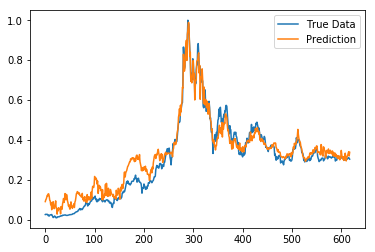

In [62]:
predicted_train_mse, predicted_train_binary = model.predict(train_X)
predicted_train_mse = predicted_train_mse.squeeze().reshape(-1,1)
predicted_train_binary = predicted_train_binary.squeeze().reshape(-1,1)
true_train = train_y.reshape(-1,1)
utils.plot_results(predicted_train_mse, true_train)

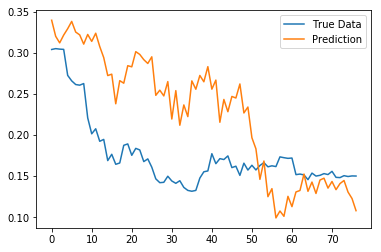

In [63]:
predicted_dev_mse, predicted_dev_binary = model.predict(dev_X)
predicted_dev_mse = predicted_dev_mse.squeeze().reshape(-1,1)
predicted_dev_binary = predicted_dev_binary.squeeze().reshape(-1,1)
true_dev = dev_y.reshape(-1,1)
utils.plot_results(predicted_dev_mse, true_dev)

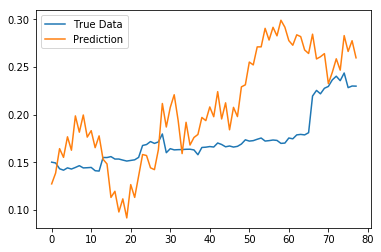

In [64]:
predicted_test_mse, predicted_test_binary = model.predict(test_X)
predicted_test_mse = predicted_test_mse.squeeze().reshape(-1,1)
predicted_test_binary = predicted_test_binary.squeeze().reshape(-1,1)
true_test = test_y.reshape(-1,1)
utils.plot_results(predicted_test_mse, true_test)

In [65]:
print("MSE Train:", mean_squared_error(predicted_train_mse, true_train))
print("MSE Dev:", mean_squared_error(predicted_dev_mse, true_dev))
print("MSE Test:", mean_squared_error(predicted_test_mse, true_test))

MSE Train: 0.0025454914242385137
MSE Dev: 0.006131844522003261
MSE Test: 0.0031461005077144085


In [66]:
true_train_acc = train_y_acc.reshape(-1,1)
true_dev_acc = dev_y_acc.reshape(-1,1)
true_test_acc = test_y_acc.reshape(-1,1)

print("Acc Train:", accuracy_score(np.array(predicted_train_mse > 0.5,dtype=np.int32), np.array(true_train_acc,dtype=np.int32)))
print("Acc Dev:", accuracy_score(np.array(predicted_dev_mse > 0.5,dtype=np.int32), np.array(true_dev_acc,dtype=np.int32)))
print("Acc Test:", accuracy_score(np.array(predicted_test_mse > 0.5,dtype=np.int32), np.array(true_test_acc,dtype=np.int32)))

print("Acc Train:", accuracy_score(np.array(predicted_train_binary > 0.5,dtype=np.int32), np.array(true_train_acc,dtype=np.int32)))
print("Acc Dev:", accuracy_score(np.array(predicted_dev_binary > 0.5,dtype=np.int32), np.array(true_dev_acc,dtype=np.int32)))
print("Acc Test:", accuracy_score(np.array(predicted_test_binary > 0.5,dtype=np.int32), np.array(true_test_acc,dtype=np.int32)))


Acc Train: 0.5339805825242718
Acc Dev: 0.45454545454545453
Acc Test: 0.6153846153846154
Acc Train: 0.9498381877022654
Acc Dev: 0.5324675324675324
Acc Test: 0.5128205128205128


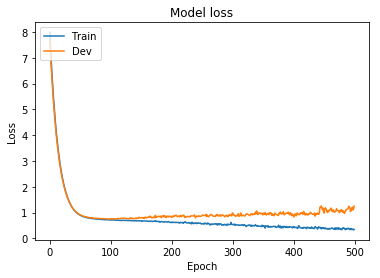

In [67]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

In [68]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.00005
decay = 1e-6
dropout_rate = 0.4
epochs = 500
batch_size = 32

Input_X = Input(shape=input_shape)
X = Conv1D(filters=64, kernel_size=3, activation='linear', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.05))(Input_X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = Conv1D(filters=96, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.05))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = MaxPooling1D(pool_size=2)(X)

X = Conv1D(filters=128, kernel_size=3, activation='linear', kernel_regularizer=regularizers.l2(0.05))(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)

X = LSTM(200, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.05))(X)
X = RepeatVector(num_out)(X)

X = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.05))(X)

X_mse = TimeDistributed(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.05)))(X)
out_mse = TimeDistributed(Dense(1))(X_mse)

X_binary = TimeDistributed(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.05)))(X)
out_binary = TimeDistributed(Dense(1, activation='sigmoid'))(X_binary)

model = Model(inputs=[Input_X], outputs=[out_mse, out_binary])

opt = Adam(lr=lr, decay=decay)
model.compile(loss=["mse", "binary_crossentropy"], optimizer=opt)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 60, 25)       0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 58, 64)       4864        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 58, 64)       256         conv1d_13[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 58, 64)       0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
dropout_13

In [69]:
history = model_funcs.train(
    model,
    train_X,
    [train_y, train_y_acc],
    (dev_X, [dev_y, dev_y_acc]),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 500 epochs, 32 batch size
Train on 618 samples, validate on 77 samples
Epoch 1/500
618/618 [==============================] - 4s 7ms/step - loss: 51.6309 - time_distributed_18_loss: 0.1201 - time_distributed_20_loss: 0.6936 - val_loss: 50.6769 - val_time_distributed_18_loss: 0.0272 - val_time_distributed_20_loss: 0.6926
Epoch 2/500
618/618 [==============================] - 1s 2ms/step - loss: 50.0217 - time_distributed_18_loss: 0.0858 - time_distributed_20_loss: 0.6930 - val_loss: 49.1200 - val_time_distributed_18_loss: 0.0206 - val_time_distributed_20_loss: 0.6928
Epoch 3/500
618/618 [==============================] - 1s 2ms/step - loss: 48.4621 - time_distributed_18_loss: 0.0559 - time_distributed_20_loss: 0.6926 - val_loss: 47.6107 - val_time_distributed_18_loss: 0.0148 - val_time_distributed_20_loss: 0.6930
Epoch 4/500
618/618 [==============================] - 1s 2ms/step - loss: 46.9763 - time_distributed_18_loss: 0.0469 - time_distributed_20_los

Epoch 66/500
618/618 [==============================] - 1s 2ms/step - loss: 6.8505 - time_distributed_18_loss: 0.0076 - time_distributed_20_loss: 0.6877 - val_loss: 6.7556 - val_time_distributed_18_loss: 0.0049 - val_time_distributed_20_loss: 0.7079
Epoch 67/500
618/618 [==============================] - 1s 2ms/step - loss: 6.6402 - time_distributed_18_loss: 0.0046 - time_distributed_20_loss: 0.6858 - val_loss: 6.5599 - val_time_distributed_18_loss: 0.0052 - val_time_distributed_20_loss: 0.7137
Epoch 68/500
618/618 [==============================] - 1s 2ms/step - loss: 6.4406 - time_distributed_18_loss: 0.0047 - time_distributed_20_loss: 0.6847 - val_loss: 6.3645 - val_time_distributed_18_loss: 0.0034 - val_time_distributed_20_loss: 0.7153
Epoch 69/500
618/618 [==============================] - 1s 2ms/step - loss: 6.2557 - time_distributed_18_loss: 0.0074 - time_distributed_20_loss: 0.6893 - val_loss: 6.1622 - val_time_distributed_18_loss: 0.0025 - val_time_distributed_20_loss: 0.7024


Epoch 99/500
618/618 [==============================] - 1s 2ms/step - loss: 2.6698 - time_distributed_18_loss: 0.0038 - time_distributed_20_loss: 0.6829 - val_loss: 2.6699 - val_time_distributed_18_loss: 0.0096 - val_time_distributed_20_loss: 0.7139
Epoch 100/500
618/618 [==============================] - 1s 2ms/step - loss: 2.6038 - time_distributed_18_loss: 0.0043 - time_distributed_20_loss: 0.6834 - val_loss: 2.5938 - val_time_distributed_18_loss: 0.0072 - val_time_distributed_20_loss: 0.7062
Epoch 101/500
618/618 [==============================] - 1s 2ms/step - loss: 2.5383 - time_distributed_18_loss: 0.0052 - time_distributed_20_loss: 0.6820 - val_loss: 2.5324 - val_time_distributed_18_loss: 0.0068 - val_time_distributed_20_loss: 0.7090
Epoch 102/500
618/618 [==============================] - 1s 2ms/step - loss: 2.4751 - time_distributed_18_loss: 0.0038 - time_distributed_20_loss: 0.6832 - val_loss: 2.4782 - val_time_distributed_18_loss: 0.0070 - val_time_distributed_20_loss: 0.71

Epoch 132/500
618/618 [==============================] - 1s 2ms/step - loss: 1.3190 - time_distributed_18_loss: 0.0049 - time_distributed_20_loss: 0.6796 - val_loss: 1.3562 - val_time_distributed_18_loss: 0.0298 - val_time_distributed_20_loss: 0.7037
Epoch 133/500
618/618 [==============================] - 1s 2ms/step - loss: 1.3005 - time_distributed_18_loss: 0.0050 - time_distributed_20_loss: 0.6825 - val_loss: 1.3246 - val_time_distributed_18_loss: 0.0256 - val_time_distributed_20_loss: 0.6974
Epoch 134/500
618/618 [==============================] - 1s 2ms/step - loss: 1.2757 - time_distributed_18_loss: 0.0045 - time_distributed_20_loss: 0.6788 - val_loss: 1.2934 - val_time_distributed_18_loss: 0.0176 - val_time_distributed_20_loss: 0.6947
Epoch 135/500
618/618 [==============================] - 1s 2ms/step - loss: 1.2569 - time_distributed_18_loss: 0.0066 - time_distributed_20_loss: 0.6783 - val_loss: 1.2971 - val_time_distributed_18_loss: 0.0316 - val_time_distributed_20_loss: 0.7

Epoch 165/500
618/618 [==============================] - 1s 2ms/step - loss: 0.8881 - time_distributed_18_loss: 0.0054 - time_distributed_20_loss: 0.6761 - val_loss: 0.9584 - val_time_distributed_18_loss: 0.0282 - val_time_distributed_20_loss: 0.7273
Epoch 166/500
618/618 [==============================] - 1s 2ms/step - loss: 0.8802 - time_distributed_18_loss: 0.0047 - time_distributed_20_loss: 0.6754 - val_loss: 0.9205 - val_time_distributed_18_loss: 0.0195 - val_time_distributed_20_loss: 0.7045
Epoch 167/500
618/618 [==============================] - 1s 2ms/step - loss: 0.8733 - time_distributed_18_loss: 0.0055 - time_distributed_20_loss: 0.6741 - val_loss: 0.9250 - val_time_distributed_18_loss: 0.0149 - val_time_distributed_20_loss: 0.7196
Epoch 168/500
618/618 [==============================] - 1s 2ms/step - loss: 0.8739 - time_distributed_18_loss: 0.0076 - time_distributed_20_loss: 0.6787 - val_loss: 0.9226 - val_time_distributed_18_loss: 0.0205 - val_time_distributed_20_loss: 0.7

Epoch 198/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7587 - time_distributed_18_loss: 0.0033 - time_distributed_20_loss: 0.6762 - val_loss: 0.8158 - val_time_distributed_18_loss: 0.0240 - val_time_distributed_20_loss: 0.7136
Epoch 199/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7566 - time_distributed_18_loss: 0.0040 - time_distributed_20_loss: 0.6752 - val_loss: 0.8118 - val_time_distributed_18_loss: 0.0261 - val_time_distributed_20_loss: 0.7094
Epoch 200/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7533 - time_distributed_18_loss: 0.0047 - time_distributed_20_loss: 0.6732 - val_loss: 0.8288 - val_time_distributed_18_loss: 0.0343 - val_time_distributed_20_loss: 0.7200
Epoch 201/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7562 - time_distributed_18_loss: 0.0036 - time_distributed_20_loss: 0.6789 - val_loss: 0.8022 - val_time_distributed_18_loss: 0.0198 - val_time_distributed_20_loss: 0.7

Epoch 231/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7161 - time_distributed_18_loss: 0.0039 - time_distributed_20_loss: 0.6694 - val_loss: 0.7834 - val_time_distributed_18_loss: 0.0177 - val_time_distributed_20_loss: 0.7232
Epoch 232/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7210 - time_distributed_18_loss: 0.0053 - time_distributed_20_loss: 0.6734 - val_loss: 0.7678 - val_time_distributed_18_loss: 0.0172 - val_time_distributed_20_loss: 0.7084
Epoch 233/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7293 - time_distributed_18_loss: 0.0062 - time_distributed_20_loss: 0.6809 - val_loss: 0.7678 - val_time_distributed_18_loss: 0.0273 - val_time_distributed_20_loss: 0.6986
Epoch 234/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7211 - time_distributed_18_loss: 0.0049 - time_distributed_20_loss: 0.6744 - val_loss: 0.7748 - val_time_distributed_18_loss: 0.0273 - val_time_distributed_20_loss: 0.7

Epoch 264/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7000 - time_distributed_18_loss: 0.0037 - time_distributed_20_loss: 0.6645 - val_loss: 0.7854 - val_time_distributed_18_loss: 0.0241 - val_time_distributed_20_loss: 0.7295
Epoch 265/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7037 - time_distributed_18_loss: 0.0041 - time_distributed_20_loss: 0.6679 - val_loss: 0.7746 - val_time_distributed_18_loss: 0.0177 - val_time_distributed_20_loss: 0.7253
Epoch 266/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7023 - time_distributed_18_loss: 0.0034 - time_distributed_20_loss: 0.6674 - val_loss: 0.7804 - val_time_distributed_18_loss: 0.0253 - val_time_distributed_20_loss: 0.7237
Epoch 267/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7055 - time_distributed_18_loss: 0.0035 - time_distributed_20_loss: 0.6706 - val_loss: 0.7682 - val_time_distributed_18_loss: 0.0179 - val_time_distributed_20_loss: 0.7

Epoch 297/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7019 - time_distributed_18_loss: 0.0052 - time_distributed_20_loss: 0.6693 - val_loss: 0.7819 - val_time_distributed_18_loss: 0.0290 - val_time_distributed_20_loss: 0.7257
Epoch 298/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6951 - time_distributed_18_loss: 0.0046 - time_distributed_20_loss: 0.6631 - val_loss: 0.7544 - val_time_distributed_18_loss: 0.0159 - val_time_distributed_20_loss: 0.7108
Epoch 299/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7105 - time_distributed_18_loss: 0.0058 - time_distributed_20_loss: 0.6768 - val_loss: 0.7639 - val_time_distributed_18_loss: 0.0229 - val_time_distributed_20_loss: 0.7132
Epoch 300/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7046 - time_distributed_18_loss: 0.0042 - time_distributed_20_loss: 0.6726 - val_loss: 0.7745 - val_time_distributed_18_loss: 0.0262 - val_time_distributed_20_loss: 0.7

Epoch 330/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6894 - time_distributed_18_loss: 0.0038 - time_distributed_20_loss: 0.6614 - val_loss: 0.7870 - val_time_distributed_18_loss: 0.0198 - val_time_distributed_20_loss: 0.7430
Epoch 331/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6973 - time_distributed_18_loss: 0.0043 - time_distributed_20_loss: 0.6688 - val_loss: 0.7556 - val_time_distributed_18_loss: 0.0162 - val_time_distributed_20_loss: 0.7152
Epoch 332/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6925 - time_distributed_18_loss: 0.0038 - time_distributed_20_loss: 0.6645 - val_loss: 0.7669 - val_time_distributed_18_loss: 0.0231 - val_time_distributed_20_loss: 0.7196
Epoch 333/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6939 - time_distributed_18_loss: 0.0031 - time_distributed_20_loss: 0.6666 - val_loss: 0.7706 - val_time_distributed_18_loss: 0.0232 - val_time_distributed_20_loss: 0.7

Epoch 363/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6866 - time_distributed_18_loss: 0.0038 - time_distributed_20_loss: 0.6593 - val_loss: 0.7717 - val_time_distributed_18_loss: 0.0159 - val_time_distributed_20_loss: 0.7324
Epoch 364/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6947 - time_distributed_18_loss: 0.0052 - time_distributed_20_loss: 0.6661 - val_loss: 0.7701 - val_time_distributed_18_loss: 0.0221 - val_time_distributed_20_loss: 0.7244
Epoch 365/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6981 - time_distributed_18_loss: 0.0047 - time_distributed_20_loss: 0.6699 - val_loss: 0.7763 - val_time_distributed_18_loss: 0.0279 - val_time_distributed_20_loss: 0.7251
Epoch 366/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6851 - time_distributed_18_loss: 0.0039 - time_distributed_20_loss: 0.6578 - val_loss: 0.7772 - val_time_distributed_18_loss: 0.0217 - val_time_distributed_20_loss: 0.7

Epoch 396/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6957 - time_distributed_18_loss: 0.0052 - time_distributed_20_loss: 0.6678 - val_loss: 0.7568 - val_time_distributed_18_loss: 0.0286 - val_time_distributed_20_loss: 0.7053
Epoch 397/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6984 - time_distributed_18_loss: 0.0067 - time_distributed_20_loss: 0.6689 - val_loss: 0.7727 - val_time_distributed_18_loss: 0.0368 - val_time_distributed_20_loss: 0.7132
Epoch 398/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6933 - time_distributed_18_loss: 0.0068 - time_distributed_20_loss: 0.6639 - val_loss: 0.7694 - val_time_distributed_18_loss: 0.0220 - val_time_distributed_20_loss: 0.7248
Epoch 399/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6893 - time_distributed_18_loss: 0.0069 - time_distributed_20_loss: 0.6598 - val_loss: 0.7558 - val_time_distributed_18_loss: 0.0196 - val_time_distributed_20_loss: 0.7

Epoch 429/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7271 - time_distributed_18_loss: 0.0145 - time_distributed_20_loss: 0.6836 - val_loss: 0.7569 - val_time_distributed_18_loss: 0.0242 - val_time_distributed_20_loss: 0.7037
Epoch 430/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7190 - time_distributed_18_loss: 0.0090 - time_distributed_20_loss: 0.6811 - val_loss: 0.7546 - val_time_distributed_18_loss: 0.0207 - val_time_distributed_20_loss: 0.7051
Epoch 431/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7129 - time_distributed_18_loss: 0.0058 - time_distributed_20_loss: 0.6786 - val_loss: 0.7518 - val_time_distributed_18_loss: 0.0208 - val_time_distributed_20_loss: 0.7027
Epoch 432/500
618/618 [==============================] - 1s 2ms/step - loss: 0.7120 - time_distributed_18_loss: 0.0058 - time_distributed_20_loss: 0.6781 - val_loss: 0.7457 - val_time_distributed_18_loss: 0.0166 - val_time_distributed_20_loss: 0.7

Epoch 462/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6926 - time_distributed_18_loss: 0.0055 - time_distributed_20_loss: 0.6627 - val_loss: 0.8170 - val_time_distributed_18_loss: 0.0251 - val_time_distributed_20_loss: 0.7674
Epoch 463/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6918 - time_distributed_18_loss: 0.0063 - time_distributed_20_loss: 0.6609 - val_loss: 0.8186 - val_time_distributed_18_loss: 0.0339 - val_time_distributed_20_loss: 0.7603
Epoch 464/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6935 - time_distributed_18_loss: 0.0049 - time_distributed_20_loss: 0.6642 - val_loss: 0.8223 - val_time_distributed_18_loss: 0.0275 - val_time_distributed_20_loss: 0.7705
Epoch 465/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6918 - time_distributed_18_loss: 0.0055 - time_distributed_20_loss: 0.6619 - val_loss: 0.7871 - val_time_distributed_18_loss: 0.0314 - val_time_distributed_20_loss: 0.7

Epoch 495/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6871 - time_distributed_18_loss: 0.0053 - time_distributed_20_loss: 0.6593 - val_loss: 0.7959 - val_time_distributed_18_loss: 0.0436 - val_time_distributed_20_loss: 0.7296
Epoch 496/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6792 - time_distributed_18_loss: 0.0045 - time_distributed_20_loss: 0.6521 - val_loss: 0.8054 - val_time_distributed_18_loss: 0.0410 - val_time_distributed_20_loss: 0.7417
Epoch 497/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6880 - time_distributed_18_loss: 0.0056 - time_distributed_20_loss: 0.6595 - val_loss: 0.7953 - val_time_distributed_18_loss: 0.0387 - val_time_distributed_20_loss: 0.7334
Epoch 498/500
618/618 [==============================] - 1s 2ms/step - loss: 0.6851 - time_distributed_18_loss: 0.0041 - time_distributed_20_loss: 0.6578 - val_loss: 0.7899 - val_time_distributed_18_loss: 0.0268 - val_time_distributed_20_loss: 0.7

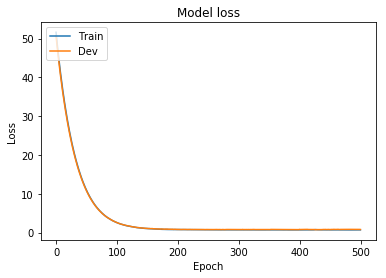

In [70]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

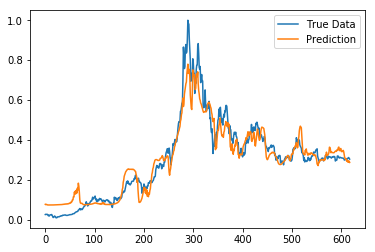

In [71]:
predicted_train_mse, predicted_train_binary = model.predict(train_X)
predicted_train_mse = predicted_train_mse.squeeze().reshape(-1,1)
predicted_train_binary = predicted_train_binary.squeeze().reshape(-1,1)
true_train = train_y.reshape(-1,1)
utils.plot_results(predicted_train_mse, true_train)

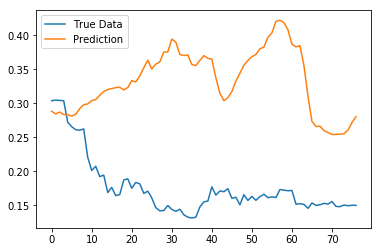

In [72]:
predicted_dev_mse, predicted_dev_binary = model.predict(dev_X)
predicted_dev_mse = predicted_dev_mse.squeeze().reshape(-1,1)
predicted_dev_binary = predicted_dev_binary.squeeze().reshape(-1,1)
true_dev = dev_y.reshape(-1,1)
utils.plot_results(predicted_dev_mse, true_dev)

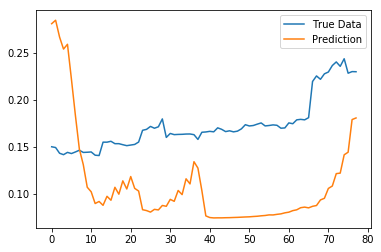

In [73]:
predicted_test_mse, predicted_test_binary = model.predict(test_X)
predicted_test_mse = predicted_test_mse.squeeze().reshape(-1,1)
predicted_test_binary = predicted_test_binary.squeeze().reshape(-1,1)
true_test = test_y.reshape(-1,1)
utils.plot_results(predicted_test_mse, true_test)

In [74]:
print("MSE Train:", mean_squared_error(predicted_train_mse, true_train))
print("MSE Dev:", mean_squared_error(predicted_dev_mse, true_dev))
print("MSE Test:", mean_squared_error(predicted_test_mse, true_test))

MSE Train: 0.0034634447329183918
MSE Dev: 0.029879524562036044
MSE Test: 0.007565084675232829


In [75]:
true_train_acc = train_y_acc.reshape(-1,1)
true_dev_acc = dev_y_acc.reshape(-1,1)
true_test_acc = test_y_acc.reshape(-1,1)

print("Acc Train:", accuracy_score(np.array(predicted_train_mse > 0.5,dtype=np.int32), np.array(true_train_acc,dtype=np.int32)))
print("Acc Dev:", accuracy_score(np.array(predicted_dev_mse > 0.5,dtype=np.int32), np.array(true_dev_acc,dtype=np.int32)))
print("Acc Test:", accuracy_score(np.array(predicted_test_mse > 0.5,dtype=np.int32), np.array(true_test_acc,dtype=np.int32)))

print("Acc Train:", accuracy_score(np.array(predicted_train_binary > 0.5,dtype=np.int32), np.array(true_train_acc,dtype=np.int32)))
print("Acc Dev:", accuracy_score(np.array(predicted_dev_binary > 0.5,dtype=np.int32), np.array(true_dev_acc,dtype=np.int32)))
print("Acc Test:", accuracy_score(np.array(predicted_test_binary > 0.5,dtype=np.int32), np.array(true_test_acc,dtype=np.int32)))


Acc Train: 0.540453074433657
Acc Dev: 0.45454545454545453
Acc Test: 0.6153846153846154
Acc Train: 0.6084142394822006
Acc Dev: 0.45454545454545453
Acc Test: 0.6538461538461539
